In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [12]:
len(words)

32033

In [13]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [57]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    # print(w)

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [59]:
C = torch.randn((27,2))

In [60]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [61]:
w1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [62]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [63]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [64]:
h = torch.tanh(emb.view(-1,6) @ w1 + b1)

In [65]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [66]:
logits = h @ w2 + b2

In [67]:
counts = logits.exp()

In [68]:
prob = counts / counts.sum(1, keepdim=True)

In [69]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [70]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [71]:
sum(p.nelement() for p in parameters)

3481

In [72]:
for p in parameters:
    p.requires_grad = True

In [99]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [118]:
lri = []
lossi = []
for i in range(10000):
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    # update
    loss.backward()

    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lr)
    lossi.append(loss.item())

print(loss.item())


2.1585819721221924


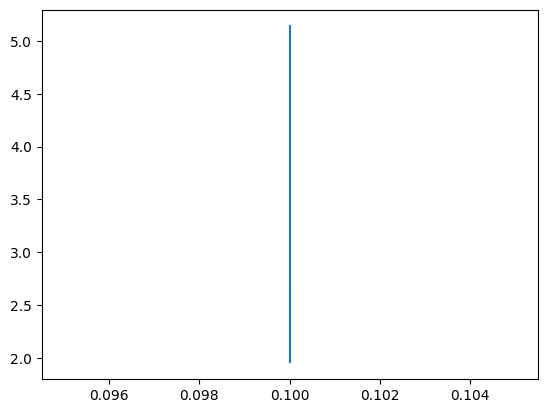

In [114]:
plt.plot(lri, lossi)

In [119]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3457, grad_fn=<NllLossBackward0>)